# Using dask for inference of deep neural networks

See [this Dask tutorial](https://examples.dask.org/machine-learning/torch-prediction.html) for the inspiration of the implementation below.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import dask
from torchvision import models

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from dask_utils import (
    load_image_wrapper, 
    predict_wrapper, 
    preprocess_image_wrapper, 
    create_batches
)

### Load images

In [2]:
images_dir = Path("../data/images/vanalleswat")
images_paths = [img for img in images_dir.glob("*") if img.suffix in ['.jpg', '.png']]

Lazy-load the images by calling the delayed `load_image` function (in `dask_utils.py`)

In [3]:
delayed_images = [load_image_wrapper(img) for img in images_paths]

In [4]:
delayed_images_preprocessed = [preprocess_image_wrapper(img) for img in delayed_images]

Since we've transformed & cropped each image, we should get back an image of shape `n_channels x height x width`

In [5]:
delayed_images_preprocessed[0].compute().shape

torch.Size([3, 224, 224])

It makes more sense to batch the images in groups of e.g. 10 and let the model predict the class for each image in a batch.

In [6]:
delayed_images_batched = create_batches(delayed_images_preprocessed, batch_size=10)

In [7]:
array_images = [
    image.compute()
    for image_idx, image 
    in enumerate(delayed_images) 
    if image_idx <= 15
]

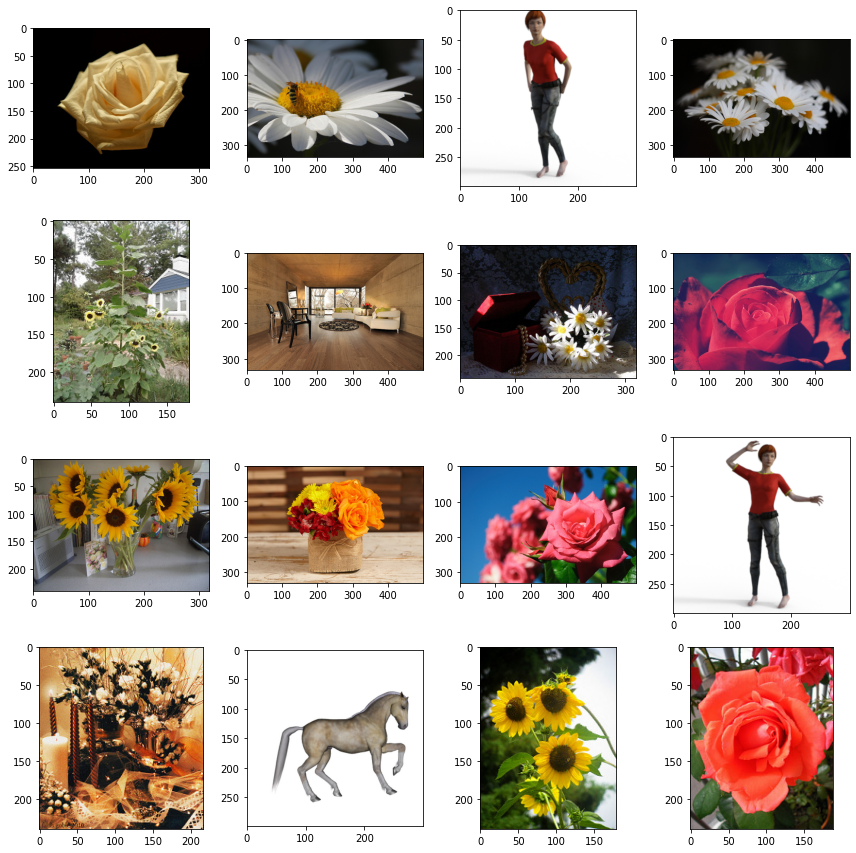

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(12,12))
ax = ax.ravel()

for ax_idx, ax in enumerate(ax):
    ax.imshow(array_images[ax_idx])

plt.tight_layout()
plt.show()

## Set up the model

To avoid having to load the model on each worker, we turn the pre-trained resnet model into a delayed object, which allows it to be passed around to each worker as necessary

In [9]:
delayed_model = dask.delayed(models.resnet50(pretrained=True).cpu().eval())

In [10]:
delayed_model

Delayed('ResNet-443c4020-5946-483a-a2f2-3087e4391cb4')

In [11]:
delayed_batch_predictions = [
    predict_wrapper(batch, delayed_model, return_class=False) 
    for batch 
    in delayed_images_batched
]

In [12]:
delayed_predictions = dask.delayed(lambda x: np.concatenate(x, axis=0))(delayed_batch_predictions)

In [13]:
# Fetch the results in main memory
predictions = delayed_predictions.compute()

I checked and this mapping from TF seems to work fine for pytorch resnet models

In [14]:
class_predictions = tf.keras.applications.resnet50.decode_predictions(
        predictions, top=5
)

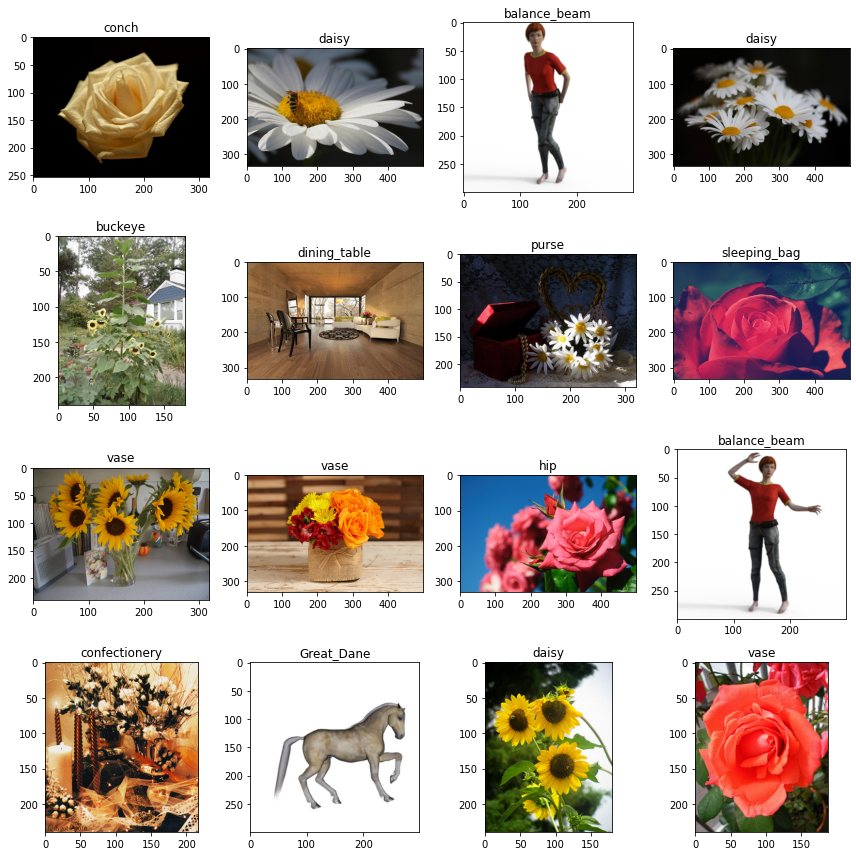

In [15]:
fig, ax = plt.subplots(4, 4, figsize=(12,12))
ax = ax.ravel()

for img_idx in range(16):

    ax[img_idx].imshow(delayed_images[img_idx].compute())
    ax[img_idx].set_title(class_predictions[img_idx][0][1])

plt.tight_layout()
plt.show()

Clearly, this requires some fine-tuning :-).

## Dask + tensorflow

Doing the same thing for tensorflow is a bit easier since we already get a lot of preprocessing functions out of the box with Keras.

In [129]:
import tensorflow as tf
import toolz
from functools import partial

def predict_class(model, batch):
    return model.predict(batch)

concatenate_predictions = partial(tf.concat, axis=0)

image_to_array_wrapper = dask.delayed(tf.keras.utils.img_to_array, name="image_to_array")

crop_array_wrapper = dask.delayed(tf.keras.layers.CenterCrop(224, 224, name="crop"), name="crop_image")

batch_image_wrapper = dask.delayed(tf.stack, name="make_batch")

preprocess_input_wrapper = dask.delayed(tf.keras.applications.resnet50.preprocess_input, name="preprocess_images")

predict_wrapper = dask.delayed(predict_class, name="predict_class")

stack_predictions_wrapper = dask.delayed(concatenate_predictions, name="stack_predictions")

model = tf.keras.applications.resnet50.ResNet50(
        include_top=True, weights='imagenet', input_tensor=None,
        input_shape=None, pooling=None, classes=1000
    )

model_delayed = dask.delayed(
    model, name="resnet"
)

Apply the preprocessing functions

In [130]:
delayed_images_tensor = [image_to_array_wrapper(img) for img in delayed_images]

delayed_images_cropped = [crop_array_wrapper(tensor) for tensor in delayed_images_tensor]

delayed_images_batched = [batch_image_wrapper(batch) for batch in toolz.partition_all(10, delayed_images_cropped)]

delayed_images_preprocessed = [preprocess_input_wrapper(tensor) for tensor in delayed_images_batched]

Predict classes for each batch & concatenate

In [131]:
predictions = [predict_wrapper(model_delayed, batch) for batch in delayed_images_preprocessed]

In [132]:
predictions_stacked = stack_predictions_wrapper(predictions)

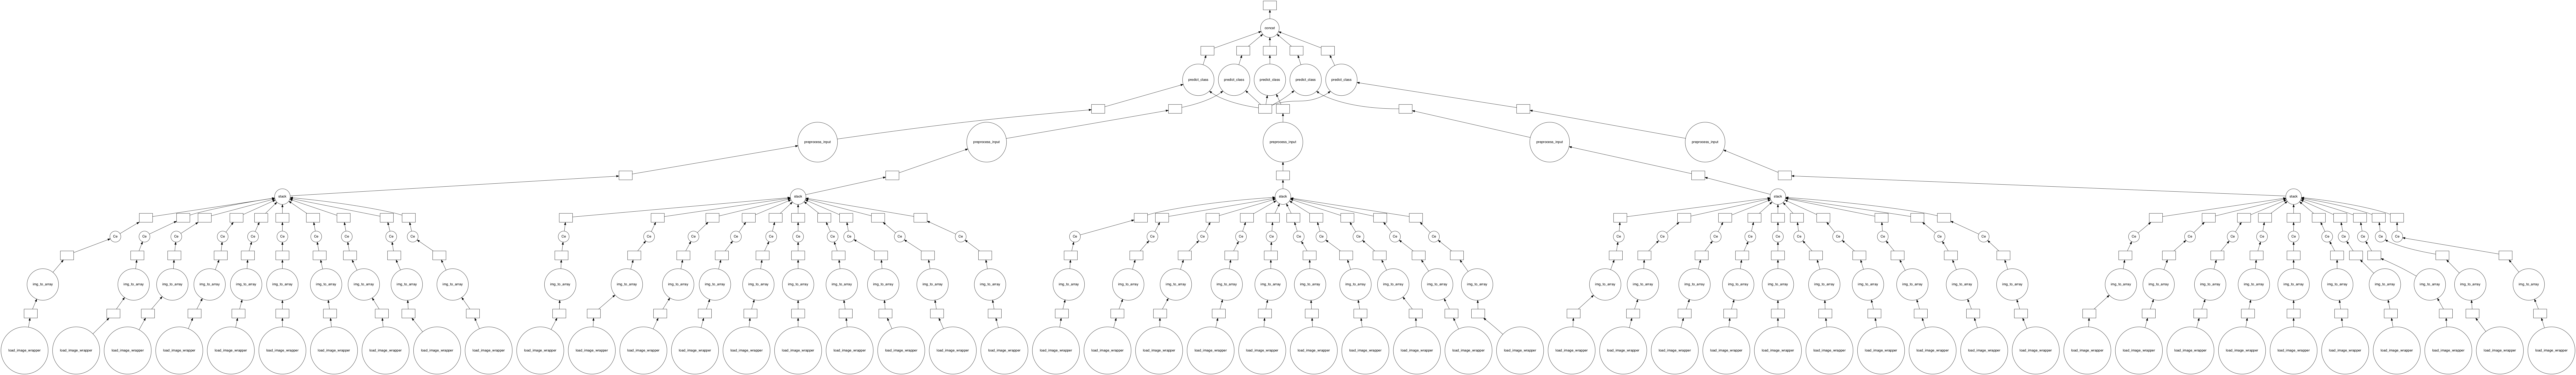

In [133]:
predictions_stacked.visualize(name="dask-tensorflow")

In [134]:
predictions_stacked_local = predictions_stacked.compute()

In [135]:
predictions_stacked_local.shape

TensorShape([50, 1000])

In [138]:
class_predictions = tf.keras.applications.resnet50.decode_predictions(
        predictions_stacked_local.numpy(), top=5
)

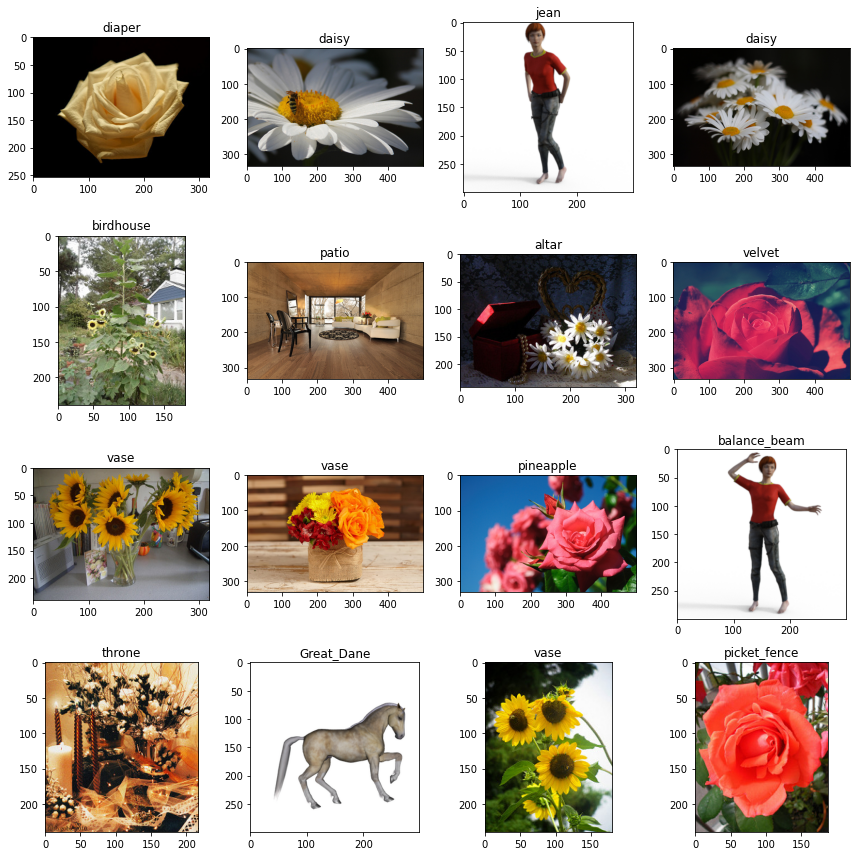

In [140]:
fig, ax = plt.subplots(4, 4, figsize=(12,12))
ax = ax.ravel()

for img_idx in range(16):

    ax[img_idx].imshow(delayed_images[img_idx].compute())
    ax[img_idx].set_title(class_predictions[img_idx][0][1])

plt.tight_layout()
plt.show()